In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Check if CUDA is available and use it if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
# Load the train and test dataframes
train_df = pd.read_csv('E:/Vehicle/train_df.csv')
test_df = pd.read_csv('E:/Vehicle/test_df.csv')

In [4]:
# Encode labels as integers
label_to_idx = {label: idx for idx, label in enumerate(train_df['Label'].unique())}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

In [5]:
# Custom dataset class
class VehicleDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Filepath']
        try:
            image = Image.open(img_path).convert('RGB')
        except (OSError, FileNotFoundError) as e:
            print(f"Error loading image {img_path}: {e}")
            # Skip this image and use a different image
            return self.__getitem__((idx + 1) % len(self.dataframe))
        
        label = self.dataframe.iloc[idx]['Label']
        label = label_to_idx[label]  # Convert string label to numerical label
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [6]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [7]:
# Create datasets and dataloaders
train_dataset = VehicleDataset(train_df, transform=transform)
test_dataset = VehicleDataset(test_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [8]:
# Load pre-trained ResNet50 model
model = models.resnet50(pretrained=True)

C:\Users\anand\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\anand\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Modify the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)  # Assuming 5 classes

model = model.to(device)

In [10]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Training the model with progress bar
def train_model(model, criterion, optimizer, train_loader, num_epochs=30):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                pbar.set_postfix({'Loss': running_loss / (pbar.n + 1), 'Accuracy': 100 * correct / total})
                pbar.update(1)
                
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader)}, Accuracy: {100 * correct / total}%')

train_model(model, criterion, optimizer, train_loader)


Epoch 1/30:  21%|████████▊                                 | 4/19 [00:33<02:04,  8.28s/batch, Loss=1.62, Accuracy=34.4]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 1/30:  32%|█████████████▎                            | 6/19 [00:49<01:46,  8.17s/batch, Loss=1.71, Accuracy=34.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 1/30:  58%|███████████████████████▋                 | 11/19 [01:27<01:01,  7.67s/batch, Loss=1.62, Accuracy=36.4]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)
Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 1/30:  74%|██████████████████████████████▏          | 14/19 [01:49<00:37,  7.47s/batch, Loss=1.57, Accuracy=36.4]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 1/30: 100%|█████████████████████████████████████████| 19/19 [02:27<00:00,  7.76s/batch, Loss=1.51, Accuracy=39.3]


Epoch [1/30], Loss: 1.5120304885663485, Accuracy: 39.32773109243698%


Epoch 2/30:  11%|████▍                                     | 2/19 [00:15<02:06,  7.47s/batch, Loss=1.22, Accuracy=56.2]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 2/30:  16%|██████▋                                   | 3/19 [00:23<02:03,  7.74s/batch, Loss=1.12, Accuracy=60.4]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 2/30:  63%|█████████████████████████▉               | 12/19 [01:27<00:50,  7.18s/batch, Loss=1.21, Accuracy=54.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 2/30:  68%|████████████████████████████▋             | 13/19 [01:34<00:43,  7.25s/batch, Loss=1.2, Accuracy=55.8]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 2/30:  79%|████████████████████████████████▎        | 15/19 [01:49<00:28,  7.25s/batch, Loss=1.22, Accuracy=55.6]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 2/30: 100%|██████████████████████████████████████████| 19/19 [02:13<00:00,  7.04s/batch, Loss=1.2, Accuracy=57.1]


Epoch [2/30], Loss: 1.197413300213061, Accuracy: 57.142857142857146%


Epoch 3/30:  42%|█████████████████▎                       | 8/19 [00:55<01:15,  6.89s/batch, Loss=0.924, Accuracy=68.4]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 3/30:  47%|███████████████████▍                     | 9/19 [01:02<01:09,  6.94s/batch, Loss=0.918, Accuracy=68.4]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 3/30:  68%|███████████████████████████▎            | 13/19 [01:31<00:43,  7.19s/batch, Loss=0.896, Accuracy=67.3]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 3/30:  89%|███████████████████████████████████▊    | 17/19 [02:05<00:16,  8.15s/batch, Loss=0.908, Accuracy=66.5]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 3/30:  95%|█████████████████████████████████████▉  | 18/19 [02:11<00:07,  7.74s/batch, Loss=0.914, Accuracy=66.5]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 3/30: 100%|████████████████████████████████████████| 19/19 [02:16<00:00,  7.17s/batch, Loss=0.935, Accuracy=65.9]


Epoch [3/30], Loss: 0.9352784595991436, Accuracy: 65.88235294117646%


Epoch 4/30:  26%|██████████▊                              | 5/19 [00:35<01:38,  7.04s/batch, Loss=0.692, Accuracy=77.5]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 4/30:  37%|███████████████                          | 7/19 [00:49<01:25,  7.15s/batch, Loss=0.732, Accuracy=76.3]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 4/30:  42%|█████████████████▎                       | 8/19 [00:56<01:19,  7.24s/batch, Loss=0.751, Accuracy=74.6]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)
Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 4/30:  53%|█████████████████████                   | 10/19 [01:12<01:08,  7.60s/batch, Loss=0.761, Accuracy=73.8]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 4/30: 100%|████████████████████████████████████████| 19/19 [02:17<00:00,  7.25s/batch, Loss=0.766, Accuracy=72.6]


Epoch [4/30], Loss: 0.7657394064100165, Accuracy: 72.60504201680672%


Epoch 5/30:  26%|██████████▊                              | 5/19 [00:38<01:49,  7.86s/batch, Loss=0.445, Accuracy=84.4]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 5/30:  42%|█████████████████▎                       | 8/19 [01:01<01:23,  7.57s/batch, Loss=0.477, Accuracy=82.8]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 5/30:  53%|█████████████████████                   | 10/19 [01:14<01:04,  7.11s/batch, Loss=0.452, Accuracy=82.8]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 5/30:  74%|█████████████████████████████▍          | 14/19 [01:40<00:34,  6.81s/batch, Loss=0.484, Accuracy=81.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 5/30:  84%|██████████████████████████████████▌      | 16/19 [01:53<00:19,  6.67s/batch, Loss=0.52, Accuracy=81.2]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 5/30: 100%|████████████████████████████████████████| 19/19 [02:10<00:00,  6.89s/batch, Loss=0.573, Accuracy=79.7]


Epoch [5/30], Loss: 0.5726392457359716, Accuracy: 79.66386554621849%


Epoch 6/30:  16%|██████▍                                  | 3/19 [00:19<01:41,  6.32s/batch, Loss=0.632, Accuracy=72.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 6/30:  26%|██████████▊                              | 5/19 [00:32<01:33,  6.71s/batch, Loss=0.598, Accuracy=76.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 6/30:  42%|█████████████████▎                       | 8/19 [00:51<01:08,  6.21s/batch, Loss=0.585, Accuracy=76.2]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 6/30:  53%|█████████████████████                   | 10/19 [01:03<00:56,  6.25s/batch, Loss=0.573, Accuracy=77.8]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 6/30:  63%|█████████████████████████▎              | 12/19 [01:17<00:46,  6.59s/batch, Loss=0.585, Accuracy=77.6]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 6/30: 100%|████████████████████████████████████████| 19/19 [02:02<00:00,  6.46s/batch, Loss=0.633, Accuracy=76.8]


Epoch [6/30], Loss: 0.6332311959643113, Accuracy: 76.80672268907563%


Epoch 7/30:   0%|                                                                            | 0/19 [00:00<?, ?batch/s]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)
Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)
Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 7/30:  21%|████████▋                                | 4/19 [00:28<01:47,  7.17s/batch, Loss=0.467, Accuracy=85.2]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 7/30:  53%|█████████████████████                   | 10/19 [01:08<00:58,  6.52s/batch, Loss=0.408, Accuracy=87.2]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 7/30: 100%|██████████████████████████████████████████| 19/19 [02:08<00:00,  6.78s/batch, Loss=0.5, Accuracy=83.9]


Epoch [7/30], Loss: 0.5004232863062307, Accuracy: 83.8655462184874%


Epoch 8/30:   5%|██▏                                      | 1/19 [00:06<01:48,  6.01s/batch, Loss=0.411, Accuracy=78.1]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 8/30:  26%|██████████▊                              | 5/19 [00:34<01:38,  7.01s/batch, Loss=0.528, Accuracy=82.5]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)
Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 8/30:  42%|█████████████████▎                       | 8/19 [00:54<01:12,  6.62s/batch, Loss=0.512, Accuracy=83.2]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 8/30:  63%|█████████████████████████▎              | 12/19 [01:20<00:45,  6.47s/batch, Loss=0.558, Accuracy=81.5]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 8/30: 100%|████████████████████████████████████████| 19/19 [02:04<00:00,  6.56s/batch, Loss=0.507, Accuracy=82.9]


Epoch [8/30], Loss: 0.5065619035771018, Accuracy: 82.85714285714286%


Epoch 9/30:   0%|                                                                            | 0/19 [00:00<?, ?batch/s]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 9/30:   5%|██▏                                      | 1/19 [00:06<02:00,  6.72s/batch, Loss=0.182, Accuracy=93.8]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 9/30:  11%|████▎                                    | 2/19 [00:13<01:55,  6.77s/batch, Loss=0.263, Accuracy=90.6]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 9/30:  84%|█████████████████████████████████▋      | 16/19 [01:45<00:20,  6.68s/batch, Loss=0.326, Accuracy=87.5]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 9/30:  95%|█████████████████████████████████████▉  | 18/19 [01:58<00:06,  6.60s/batch, Loss=0.316, Accuracy=88.2]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 9/30: 100%|████████████████████████████████████████| 19/19 [02:01<00:00,  6.42s/batch, Loss=0.306, Accuracy=88.6]


Epoch [9/30], Loss: 0.3060591369867325, Accuracy: 88.57142857142857%


Epoch 10/30:   5%|██                                      | 1/19 [00:06<01:56,  6.45s/batch, Loss=0.116, Accuracy=96.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 10/30:  11%|████▏                                   | 2/19 [00:13<01:55,  6.80s/batch, Loss=0.165, Accuracy=96.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 10/30:  37%|███████████████▍                          | 7/19 [00:45<01:14,  6.23s/batch, Loss=0.192, Accuracy=96]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 10/30:  42%|████████████████▊                       | 8/19 [00:51<01:09,  6.28s/batch, Loss=0.253, Accuracy=94.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 10/30:  84%|████████████████████████████████▊      | 16/19 [01:45<00:19,  6.66s/batch, Loss=0.308, Accuracy=92.6]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 10/30: 100%|███████████████████████████████████████| 19/19 [02:00<00:00,  6.35s/batch, Loss=0.309, Accuracy=92.4]


Epoch [10/30], Loss: 0.3087121381571418, Accuracy: 92.43697478991596%


Epoch 11/30:  11%|████▏                                   | 2/19 [00:13<01:52,  6.59s/batch, Loss=0.121, Accuracy=98.4]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)
Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 11/30:  63%|████████████████████████▋              | 12/19 [01:19<00:46,  6.67s/batch, Loss=0.244, Accuracy=92.7]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 11/30:  68%|████████████████████████████             | 13/19 [01:25<00:39,  6.65s/batch, Loss=0.235, Accuracy=93]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)
Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 11/30: 100%|███████████████████████████████████████| 19/19 [02:03<00:00,  6.50s/batch, Loss=0.267, Accuracy=90.9]


Epoch [11/30], Loss: 0.2666760918341185, Accuracy: 90.92436974789916%


Epoch 12/30:  11%|████▏                                   | 2/19 [00:12<01:45,  6.22s/batch, Loss=0.144, Accuracy=95.3]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 12/30:  21%|████████▍                               | 4/19 [00:24<01:32,  6.14s/batch, Loss=0.154, Accuracy=94.5]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 12/30:  58%|███████████████████████▋                 | 11/19 [01:11<00:51,  6.43s/batch, Loss=0.232, Accuracy=92]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 12/30:  63%|█████████████████████████▎              | 12/19 [01:17<00:44,  6.38s/batch, Loss=0.22, Accuracy=92.4]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 12/30:  95%|████████████████████████████████████▉  | 18/19 [01:58<00:07,  7.05s/batch, Loss=0.246, Accuracy=91.1]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 12/30: 100%|███████████████████████████████████████| 19/19 [02:02<00:00,  6.44s/batch, Loss=0.247, Accuracy=91.3]


Epoch [12/30], Loss: 0.24692570653400922, Accuracy: 91.26050420168067%


Epoch 13/30:  16%|██████▎                                 | 3/19 [00:18<01:39,  6.24s/batch, Loss=0.157, Accuracy=93.8]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)
Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 13/30:  26%|██████████▌                             | 5/19 [00:32<01:31,  6.52s/batch, Loss=0.169, Accuracy=93.1]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 13/30:  63%|████████████████████████▋              | 12/19 [01:18<00:46,  6.63s/batch, Loss=0.213, Accuracy=93.2]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 13/30:  79%|██████████████████████████████▊        | 15/19 [01:37<00:26,  6.53s/batch, Loss=0.225, Accuracy=92.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 13/30: 100%|███████████████████████████████████████| 19/19 [02:03<00:00,  6.50s/batch, Loss=0.209, Accuracy=93.3]


Epoch [13/30], Loss: 0.20949113486628784, Accuracy: 93.27731092436974%


Epoch 14/30:  42%|████████████████▊                       | 8/19 [00:51<01:09,  6.35s/batch, Loss=0.193, Accuracy=94.1]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 14/30:  53%|████████████████████▌                  | 10/19 [01:06<01:02,  6.91s/batch, Loss=0.184, Accuracy=94.1]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 14/30:  84%|████████████████████████████████▊      | 16/19 [01:46<00:19,  6.64s/batch, Loss=0.187, Accuracy=94.3]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)
Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)
Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 14/30: 100%|███████████████████████████████████████| 19/19 [02:04<00:00,  6.57s/batch, Loss=0.185, Accuracy=94.5]


Epoch [14/30], Loss: 0.1852072571453295, Accuracy: 94.45378151260505%


Epoch 15/30:  32%|████████████▋                           | 6/19 [00:42<01:34,  7.29s/batch, Loss=0.184, Accuracy=94.8]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)
Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 15/30:  37%|██████████████▋                         | 7/19 [00:49<01:26,  7.20s/batch, Loss=0.223, Accuracy=92.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 15/30:  74%|████████████████████████████▋          | 14/19 [01:34<00:33,  6.65s/batch, Loss=0.167, Accuracy=94.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 15/30:  79%|██████████████████████████████▊        | 15/19 [01:40<00:25,  6.45s/batch, Loss=0.168, Accuracy=94.8]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 15/30: 100%|██████████████████████████████████████████| 19/19 [02:06<00:00,  6.66s/batch, Loss=0.17, Accuracy=95]


Epoch [15/30], Loss: 0.17002069871676595, Accuracy: 94.95798319327731%


Epoch 16/30:  16%|██████▎                                 | 3/19 [00:19<01:44,  6.52s/batch, Loss=0.116, Accuracy=97.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 16/30:  32%|████████████▎                          | 6/19 [00:40<01:31,  7.07s/batch, Loss=0.0838, Accuracy=97.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 16/30:  63%|████████████████████████▋              | 12/19 [01:21<00:47,  6.72s/batch, Loss=0.159, Accuracy=94.8]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 16/30:  74%|██████████████████████████████▏          | 14/19 [01:37<00:37,  7.40s/batch, Loss=0.182, Accuracy=94]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 16/30:  95%|████████████████████████████████████▉  | 18/19 [02:05<00:07,  7.10s/batch, Loss=0.179, Accuracy=94.3]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 16/30: 100%|███████████████████████████████████████| 19/19 [02:09<00:00,  6.84s/batch, Loss=0.172, Accuracy=94.5]


Epoch [16/30], Loss: 0.17209467453587995, Accuracy: 94.45378151260505%


Epoch 17/30:  16%|██████▍                                  | 3/19 [00:18<01:38,  6.14s/batch, Loss=0.15, Accuracy=92.7]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 17/30:  47%|██████████████████▉                     | 9/19 [01:00<01:07,  6.72s/batch, Loss=0.164, Accuracy=93.8]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 17/30:  53%|████████████████████▌                  | 10/19 [01:06<00:59,  6.61s/batch, Loss=0.153, Accuracy=94.4]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 17/30:  68%|██████████████████████████▋            | 13/19 [01:27<00:41,  6.91s/batch, Loss=0.195, Accuracy=94.2]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 17/30:  79%|██████████████████████████████▊        | 15/19 [01:42<00:28,  7.09s/batch, Loss=0.185, Accuracy=94.4]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 17/30: 100%|███████████████████████████████████████| 19/19 [02:06<00:00,  6.63s/batch, Loss=0.201, Accuracy=93.8]


Epoch [17/30], Loss: 0.20104974978848508, Accuracy: 93.78151260504201%


Epoch 18/30:  63%|█████████████████████████▎              | 12/19 [01:22<00:45,  6.53s/batch, Loss=0.17, Accuracy=94.5]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 18/30:  84%|████████████████████████████████▊      | 16/19 [01:51<00:21,  7.11s/batch, Loss=0.182, Accuracy=93.6]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 18/30:  89%|██████████████████████████████████▉    | 17/19 [01:56<00:13,  6.67s/batch, Loss=0.188, Accuracy=93.2]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)
Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 18/30:  95%|████████████████████████████████████▉  | 18/19 [02:03<00:06,  6.65s/batch, Loss=0.196, Accuracy=92.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 18/30: 100%|███████████████████████████████████████| 19/19 [02:07<00:00,  6.71s/batch, Loss=0.189, Accuracy=93.1]


Epoch [18/30], Loss: 0.1886526703050262, Accuracy: 93.10924369747899%


Epoch 19/30:   0%|                                                                           | 0/19 [00:00<?, ?batch/s]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 19/30:  58%|██████████████████████▌                | 11/19 [01:12<00:51,  6.42s/batch, Loss=0.143, Accuracy=95.2]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 19/30:  74%|████████████████████████████▋          | 14/19 [01:32<00:33,  6.62s/batch, Loss=0.128, Accuracy=95.5]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)
Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 19/30:  84%|████████████████████████████████▊      | 16/19 [01:46<00:20,  6.82s/batch, Loss=0.132, Accuracy=95.5]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 19/30: 100%|███████████████████████████████████████| 19/19 [02:03<00:00,  6.52s/batch, Loss=0.131, Accuracy=95.3]


Epoch [19/30], Loss: 0.131411388712494, Accuracy: 95.29411764705883%


Epoch 20/30:   5%|██                                      | 1/19 [00:06<02:00,  6.71s/batch, Loss=0.0291, Accuracy=100]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 20/30:  63%|████████████████████████              | 12/19 [01:21<00:47,  6.79s/batch, Loss=0.0764, Accuracy=97.4]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 20/30:  79%|██████████████████████████████▊        | 15/19 [01:42<00:27,  6.84s/batch, Loss=0.076, Accuracy=97.5]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 20/30:  84%|████████████████████████████████      | 16/19 [01:49<00:20,  6.95s/batch, Loss=0.0791, Accuracy=97.5]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 20/30:  89%|██████████████████████████████████    | 17/19 [01:55<00:13,  6.76s/batch, Loss=0.0806, Accuracy=97.2]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 20/30: 100%|██████████████████████████████████████| 19/19 [02:07<00:00,  6.69s/batch, Loss=0.0838, Accuracy=97.1]


Epoch [20/30], Loss: 0.08378235554616702, Accuracy: 97.14285714285714%


Epoch 21/30:   5%|██                                     | 1/19 [00:07<02:15,  7.53s/batch, Loss=0.00638, Accuracy=100]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 21/30:  11%|████                                   | 2/19 [00:13<01:57,  6.89s/batch, Loss=0.00779, Accuracy=100]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 21/30:  32%|████████████▎                          | 6/19 [00:41<01:27,  6.75s/batch, Loss=0.0669, Accuracy=98.4]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 21/30:  42%|████████████████▍                      | 8/19 [00:55<01:16,  6.93s/batch, Loss=0.0588, Accuracy=98.8]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 21/30:  63%|████████████████████████              | 12/19 [01:21<00:46,  6.60s/batch, Loss=0.0733, Accuracy=98.4]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 21/30: 100%|██████████████████████████████████████| 19/19 [02:06<00:00,  6.66s/batch, Loss=0.0808, Accuracy=98.2]


Epoch [21/30], Loss: 0.08084911492800242, Accuracy: 98.15126050420169%


Epoch 22/30:   0%|                                                                           | 0/19 [00:00<?, ?batch/s]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 22/30:  16%|██████▎                                 | 3/19 [00:20<01:47,  6.70s/batch, Loss=0.0296, Accuracy=100]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 22/30:  32%|████████████▎                          | 6/19 [00:41<01:29,  6.88s/batch, Loss=0.0915, Accuracy=96.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 22/30:  58%|██████████████████████▌                | 11/19 [01:13<00:50,  6.28s/batch, Loss=0.101, Accuracy=96.6]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 22/30:  95%|████████████████████████████████████▉  | 18/19 [02:01<00:06,  6.83s/batch, Loss=0.122, Accuracy=96.5]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 22/30: 100%|███████████████████████████████████████| 19/19 [02:05<00:00,  6.59s/batch, Loss=0.121, Accuracy=96.6]


Epoch [22/30], Loss: 0.12127489684835861, Accuracy: 96.63865546218487%


Epoch 23/30:   0%|                                                                           | 0/19 [00:00<?, ?batch/s]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 23/30:  37%|██████████████▎                        | 7/19 [00:47<01:22,  6.84s/batch, Loss=0.0766, Accuracy=98.2]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 23/30:  42%|████████████████▊                       | 8/19 [00:54<01:15,  6.85s/batch, Loss=0.144, Accuracy=96.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 23/30:  47%|███████████████████▍                     | 9/19 [01:03<01:13,  7.40s/batch, Loss=0.15, Accuracy=96.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 23/30:  63%|████████████████████████▋              | 12/19 [01:23<00:49,  7.05s/batch, Loss=0.141, Accuracy=96.6]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 23/30: 100%|███████████████████████████████████████| 19/19 [02:07<00:00,  6.70s/batch, Loss=0.149, Accuracy=96.5]


Epoch [23/30], Loss: 0.1493540887328747, Accuracy: 96.47058823529412%


Epoch 24/30:  11%|████▏                                   | 2/19 [00:14<02:04,  7.30s/batch, Loss=0.0312, Accuracy=100]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 24/30:  37%|███████████████▍                          | 7/19 [00:49<01:22,  6.87s/batch, Loss=0.113, Accuracy=96]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 24/30:  53%|████████████████████▌                  | 10/19 [01:10<01:03,  7.00s/batch, Loss=0.103, Accuracy=96.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 24/30:  74%|████████████████████████████▋          | 14/19 [01:35<00:32,  6.54s/batch, Loss=0.131, Accuracy=96.4]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)
Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 24/30: 100%|███████████████████████████████████████| 19/19 [02:07<00:00,  6.73s/batch, Loss=0.157, Accuracy=95.5]


Epoch [24/30], Loss: 0.15689088021846195, Accuracy: 95.46218487394958%


Epoch 25/30:   5%|██                                      | 1/19 [00:06<01:56,  6.49s/batch, Loss=0.0423, Accuracy=100]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 25/30:  16%|██████▎                                 | 3/19 [00:20<01:48,  6.79s/batch, Loss=0.143, Accuracy=97.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 25/30:  32%|████████████▋                           | 6/19 [00:38<01:21,  6.27s/batch, Loss=0.138, Accuracy=96.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 25/30:  37%|██████████████▋                         | 7/19 [00:45<01:18,  6.58s/batch, Loss=0.157, Accuracy=96.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 25/30:  42%|████████████████▊                       | 8/19 [00:52<01:13,  6.72s/batch, Loss=0.148, Accuracy=96.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 25/30: 100%|███████████████████████████████████████| 19/19 [02:04<00:00,  6.54s/batch, Loss=0.143, Accuracy=96.5]


Epoch [25/30], Loss: 0.14273397938201302, Accuracy: 96.47058823529412%


Epoch 26/30:  16%|██████▋                                   | 3/19 [00:20<01:49,  6.86s/batch, Loss=0.077, Accuracy=99]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 26/30:  32%|████████████▉                            | 6/19 [00:39<01:24,  6.54s/batch, Loss=0.0713, Accuracy=99]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 26/30:  37%|██████████████▋                         | 7/19 [00:47<01:21,  6.83s/batch, Loss=0.072, Accuracy=98.7]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 26/30:  42%|████████████████▍                      | 8/19 [00:53<01:13,  6.70s/batch, Loss=0.0672, Accuracy=98.8]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 26/30:  95%|████████████████████████████████████  | 18/19 [02:00<00:06,  6.64s/batch, Loss=0.0693, Accuracy=97.9]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 26/30: 100%|████████████████████████████████████████| 19/19 [02:04<00:00,  6.54s/batch, Loss=0.0687, Accuracy=98]


Epoch [26/30], Loss: 0.06874820364541129, Accuracy: 97.98319327731092%


Epoch 27/30:  16%|██████▍                                  | 3/19 [00:20<01:49,  6.85s/batch, Loss=0.0271, Accuracy=99]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 27/30:  21%|████████▏                              | 4/19 [00:27<01:44,  6.99s/batch, Loss=0.0246, Accuracy=99.2]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 27/30:  32%|█████████████▌                             | 6/19 [00:41<01:30,  6.98s/batch, Loss=0.04, Accuracy=99]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 27/30:  47%|██████████████████▍                    | 9/19 [01:01<01:05,  6.53s/batch, Loss=0.0293, Accuracy=99.3]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 27/30:  68%|██████████████████████████            | 13/19 [01:28<00:39,  6.64s/batch, Loss=0.0244, Accuracy=99.5]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 27/30: 100%|██████████████████████████████████████| 19/19 [02:05<00:00,  6.60s/batch, Loss=0.0236, Accuracy=99.5]


Epoch [27/30], Loss: 0.023648804746029015, Accuracy: 99.49579831932773%


Epoch 28/30:  21%|████████▏                              | 4/19 [00:27<01:44,  6.97s/batch, Loss=0.00863, Accuracy=100]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)
Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 28/30:  53%|█████████████████████                   | 10/19 [01:08<01:03,  7.07s/batch, Loss=0.012, Accuracy=100]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 28/30:  58%|██████████████████████                | 11/19 [01:17<01:00,  7.54s/batch, Loss=0.0191, Accuracy=99.7]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 28/30:  89%|██████████████████████████████████    | 17/19 [01:58<00:13,  6.86s/batch, Loss=0.0161, Accuracy=99.6]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 28/30: 100%|███████████████████████████████████████| 19/19 [02:09<00:00,  6.81s/batch, Loss=0.015, Accuracy=99.7]


Epoch [28/30], Loss: 0.0150231136205165, Accuracy: 99.66386554621849%


Epoch 29/30:  11%|████▏                                   | 2/19 [00:14<01:58,  6.98s/batch, Loss=0.0165, Accuracy=100]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)
Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 29/30:  37%|██████████████▎                        | 7/19 [00:48<01:23,  6.99s/batch, Loss=0.0252, Accuracy=99.6]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 29/30:  74%|████████████████████████████          | 14/19 [01:36<00:33,  6.61s/batch, Loss=0.0238, Accuracy=99.3]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 29/30:  89%|██████████████████████████████████    | 17/19 [01:57<00:13,  6.89s/batch, Loss=0.0198, Accuracy=99.4]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 29/30: 100%|██████████████████████████████████████| 19/19 [02:07<00:00,  6.69s/batch, Loss=0.0184, Accuracy=99.5]


Epoch [29/30], Loss: 0.018386745972460823, Accuracy: 99.49579831932773%


Epoch 30/30:  16%|██████▏                                | 3/19 [00:18<01:40,  6.27s/batch, Loss=0.00935, Accuracy=100]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210508_10_11_26_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (39 bytes not processed)


Epoch 30/30:  26%|██████████▎                            | 5/19 [00:32<01:35,  6.80s/batch, Loss=0.00684, Accuracy=100]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Bus\20210518_14_58_52_000_RMkLr8rWJDMBfnDv6WRtqfoMLT83_F_3264_2448.jpg: image file is truncated (111 bytes not processed)


Epoch 30/30:  42%|████████████████▍                      | 8/19 [00:52<01:11,  6.47s/batch, Loss=0.00519, Accuracy=100]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Auto\Datacluster Auto (61).jpg: image file is truncated (43 bytes not processed)


Epoch 30/30:  53%|████████████████████                  | 10/19 [01:06<01:00,  6.71s/batch, Loss=0.00581, Accuracy=100]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Tempo Traveller\20210517_06_39_54_000_bsfUf1M1E9bMsvY4ENiWwUWjDQp2_F_4160_3120.jpg: image file is truncated (15 bytes not processed)


Epoch 30/30:  79%|██████████████████████████████        | 15/19 [01:41<00:27,  6.95s/batch, Loss=0.00437, Accuracy=100]

Error loading image E:\Vehicle\Vehicle_5_classes_sample\Truck\Datacluster Truck (123).jpg: image file is truncated (8 bytes not processed)


Epoch 30/30: 100%|█████████████████████████████████████| 19/19 [02:05<00:00,  6.58s/batch, Loss=0.00883, Accuracy=99.8]

Epoch [30/30], Loss: 0.008831676754389742, Accuracy: 99.83193277310924%


In [12]:
 #Save the model
torch.save(model.state_dict(), 'E:/Vehicle/model/resnet50_model.pth')

In [16]:
# Evaluation
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f'Test Accuracy: {100 * correct / total}%')

Test Accuracy: 61.74496644295302%


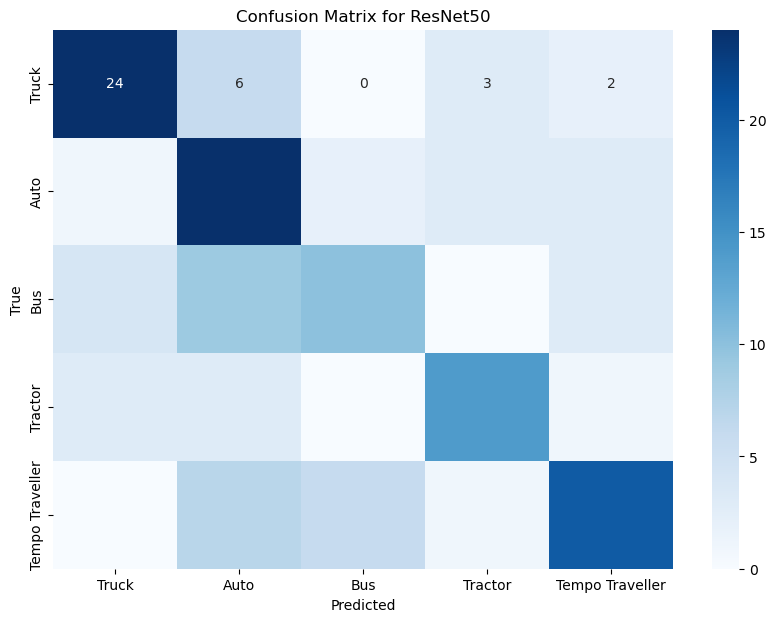

                 precision    recall  f1-score   support

          Truck       0.75      0.69      0.72        35
           Auto       0.49      0.73      0.59        33
            Bus       0.56      0.38      0.45        26
        Tractor       0.67      0.67      0.67        21
Tempo Traveller       0.69      0.59      0.63        34

       accuracy                           0.62       149
      macro avg       0.63      0.61      0.61       149
   weighted avg       0.63      0.62      0.62       149



In [17]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for ResNet50')
plt.show()

# Classification report
print(classification_report(all_labels, all_preds, target_names=list(label_to_idx.keys())))

Model Test Accuracy: 61.74%


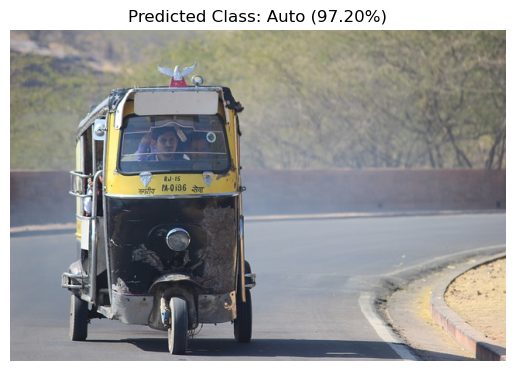

Predicted Class: Auto with Prediction Accuracy: 97.20%


In [24]:
import cv2
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Assuming the model and other variables are already defined above this point
# device, label_to_idx, idx_to_label, transform, model

# Load the model weights
model.load_state_dict(torch.load('E:/Vehicle/model/resnet50_model.pth'))
model.eval()

# Function to evaluate the model accuracy on the test dataset
def evaluate_model(test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Function to predict the class of a given image
def predict_image(image_path):
    # Load and preprocess the image
    image = Image.open(image_path).convert('RGB')
    image = transform(image)  # Apply the same transformations as used during training
    image = image.unsqueeze(0)  # Add a batch dimension

    # Move the image to the appropriate device
    image = image.to(device)

    # Make predictions
    with torch.no_grad():
        outputs = model(image)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
        predicted_class_idx = predicted.item()
        predicted_label = idx_to_label[predicted_class_idx]
        accuracy = probabilities[0][predicted_class_idx].item() * 100

    # Load the image using OpenCV for displaying
    img_cv2 = cv2.imread(image_path)
    img_cv2 = cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Display the image and predicted class label with accuracy
    plt.imshow(img_cv2)
    plt.title(f'Predicted Class: {predicted_label} ({accuracy:.2f}%)')
    plt.axis('off')
    plt.show()

    return predicted_label, accuracy

# Calculate the overall model accuracy on the test dataset
test_accuracy = evaluate_model(test_loader)
print(f'Model Test Accuracy: {test_accuracy:.2f}%')

# Example usage to predict and display the class of a single image
image_path =r'C:\Users\anand\Downloads\rickshaw-1196193_640.jpg'
predicted_label, accuracy = predict_image(image_path)
print(f"Predicted Class: {predicted_label} with Prediction Accuracy: {accuracy:.2f}%")
